In [116]:
import qutip.core.gates
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from datetime import datetime

In [117]:
# Define basic operators
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

def print_gadget(gadget):
    # Build and print the tensor representation
    tensor_representation = []
    for op in gadget:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        # Check for 0.5(I - Z)
        elif (
            isinstance(op, Qobj)  # Ensure it's a Qobj
            and op.dims == I.dims  # Match single-qubit operator dimensions
            and np.allclose(op.full(), (0.5 * I - 0.5 * Z).full())  # Compare matrices
        ):
            tensor_representation.append("1/2(I-Z)")
        # Fallback for unknown operators
        else:
            tensor_representation.append("Unknown")
    
    print(f"tensor({', '.join(tensor_representation)})")
    
    
def tensor_to_str(operator):
    # Build and print the tensor representation
    tensor_representation = []
    for op in operator:
        # Check for identity
        if op == I:
            tensor_representation.append("I")
        # Check for standard operators
        elif op == X:
            tensor_representation.append("X")
        elif op == Z:
            tensor_representation.append("Z")
        elif op == Y:
            tensor_representation.append("Y")
        else:
            tensor_representation.append("Unknown")
    
    return f"{''.join(tensor_representation)}"

In [118]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            sign = '-' if amplitude.real < 0 else '+'
            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{sign} {abs_amplitude:.2f}|{binary_state}⟩")

    # Removing the first sign
    if superposition and superposition[0][0] == '+':
        superposition[0] = superposition[0][2:]

    superposition_str = ' '.join(superposition).replace('+-', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")
    
def does_commute(A, B):
    """
    Check if two tensors A and B are commutative.
    :param A: Qobj
    :param B: Qobj
    :return: Boolean
    """
    zero_mat = A * 0
    if commutator(A, B) == zero_mat:
        return True
    return False

In [119]:
def prep_aux_gad_jordan(k, current_position, tot_space):
    # Construct the ancillary Hamiltonian
    H_accum = []
    for i in range(k):
        for j in range(i + 1, k):
            # Construct the pairwise interaction term for the ancillary space
            ZZ = [(Z if idx == i or idx == j else I) for idx in range(k)]
            aux_H = 0.5*(tensor([I for _ in range(k)]) - tensor(ZZ))
            
            # Embed aux_H into the full space
            pre_space = [I for _ in range(current_position)]  # Identities before this auxiliary block
            post_space = [I for _ in range(tot_space - current_position - k)]  # Identities after this block
            full_aux_H = tensor(pre_space + [aux_H] + post_space)
            
            
            test = 0.5 * (tensor([I for _ in range(tot_space)]) - tensor(pre_space + ZZ + post_space))
            H_accum.append(test)
            
            # ###### FOR PRINTING Aux #######
            # to_p = (pre_space + ZZ + post_space)
            # print_gadget(to_p)
            # ###### FOR PRINTING Aux #######
    return H_accum


def prep_v_gad(k, op, index, j, aux_count_v, current_position, ks):
    logical_operator = tensor(
        [op if i == j else I for i in range(total_logic_qbits)]
    )
    aux = [X if i == aux_count_v else I for i in range(k)]
    auxiliary_operator = tensor(aux)
    
    # Embed auxiliary operator into the full auxiliary space
    pre_aux = [I for _ in range(current_position - total_logic_qbits)]  # Identities for earlier stabilizers
    post_aux = [I for _ in range(sum(ks[index + 1:]))]  # Identities for remaining stabilizers
    full_auxiliary_operator = tensor(pre_aux + [auxiliary_operator] + post_aux)
    
    # Combine logical and full auxiliary operators
    full_v = tensor(logical_operator, full_auxiliary_operator)            

    # ####### FOR PRINTING V #######
    # to_p = [op if i == j else I for i in range(total_logic_qbits)] + pre_aux + aux + post_aux
    # print_gadget(to_p)
    # # full_v = tensor(to_p)
    # ####### FOR PRINTING V #######
    
    return full_v
    

def prep_gadget(perturbation_factor, hs, total_logic_qbits):
    ks = [sum(1 for op in operator if op != I) for operator in hs]  # Auxiliary qubits for each stabilizer
    tot_space = total_logic_qbits + sum(ks)
    
    # Initialize the total Hamiltonian
    H_gad = []
    V = 0
 
    current_position = total_logic_qbits  # Start after logical qubits

    for index, operator in enumerate(hs):        
        k = ks[index]
        # Build auxiliary Hamiltonians and embed them 1/2(I - ZiZj)       
        H_gad_h = prep_aux_gad_jordan(k, current_position, tot_space)
        
        # Now adding the perturbative terms
        aux_count_v = 0
        for j, op in enumerate(operator):
            if op == I:
                continue     
            
            full_v = prep_v_gad(k, op, index, j, aux_count_v, current_position, ks)
            aux_count_v += 1
            
            H_gad_h.append(perturbation_factor*full_v)
            V += full_v
        
        current_position += k
        
        fact = (math.factorial(k-1) /
                (-k*(-perturbation_factor)**k))
        # fact = 1
        H_gad.append([fact * i for i in H_gad_h])

    return H_gad, ks, V

[-1. -1. -1. -1.  1.  1.  1.  1.]


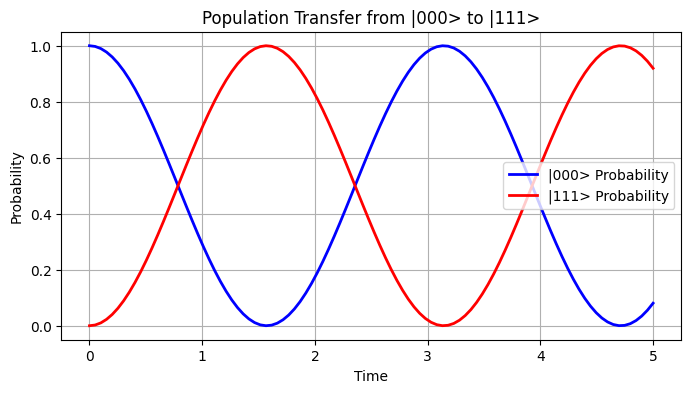

In [125]:
T_protocol = 5  # Total protocol duration (extended)
times = np.linspace(0, T_protocol, 100)  # Time range for the evolution

X_L = [X, X, X]
XXX = tensor(X_L)
total_qubits = len(X_L)

energies = XXX.eigenenergies()
print(energies)
gap = 2

H = XXX
# Create the QobjEvo for the time-dependent Hamiltonian
H_pulse = QobjEvo(H)

# Define basis states for |000> and |111>
state_000 = tensor([basis(2, 0) for _ in range(total_qubits)])
state_111 = tensor([basis(2, 1) for _ in range(total_qubits)])

P0 = state_000 * state_000.dag()
P1 = state_111 * state_111.dag()

# Solve the system using sesolve
result = sesolve(H_pulse, state_000, times, e_ops=[P0, P1])

zero_exp = result.expect[0]
one_exp = result.expect[1]

# Plot results
plt.figure(figsize=(8, 4))
plt.plot(times, zero_exp, label="|000> Probability", color='blue', linewidth=2)
plt.plot(times, one_exp, label="|111> Probability", color='red', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Probability")
plt.title("Population Transfer from |000> to |111>")
plt.legend()
plt.grid()
plt.show()

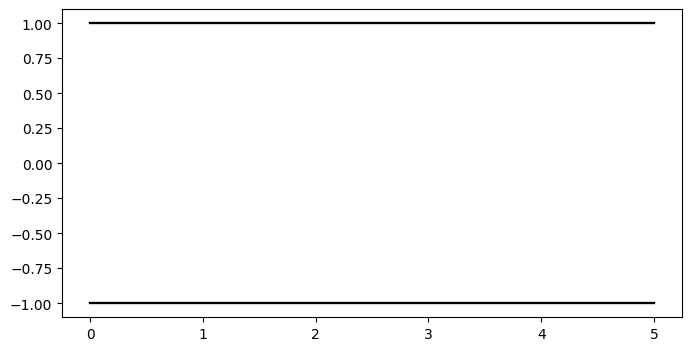

In [121]:
energy_spectrum = []
for t_step in times:
    H_t = H
    energies = H_t.eigenenergies()
    energy_spectrum.append(energies)
    
energy_spectrum = np.array(energy_spectrum)

n_qubits = 3
# Plot the energy spectrum
plt.figure(figsize=(8, 4))
for i in range(2**n_qubits):
    plt.plot(times, energy_spectrum[:, i], color='black')

In [126]:
X_L = [X, X, X]

hs = [X_L]

# Parameters
total_logic_qbits = len(hs[0]) # Number of logical qubits
perturbation_factor = 0.1

H_gad, ks, V = prep_gadget(perturbation_factor, hs, total_logic_qbits)

scipy_sparse_matrix = V.data.as_scipy()
dense_matrix = scipy_sparse_matrix.toarray()
operator_norm = np.linalg.norm(dense_matrix, ord=2)

# Print the operator norm
print(f"Operator norm of M: {V.norm()}")
print(f"so gamma has to be lower then: {gap / V.norm()}")

X_k = tensor(I,I,I,X,X,X)

Operator norm of M: 1039.5290039756376
so gamma has to be lower then: 0.0019239482422819176


|ψ⟩ = 0.50|000000000⟩ + 0.50|000000111⟩ + 0.50|000111000⟩ + 0.50|000111111⟩
0.08046788325241415 0.9195321167475856


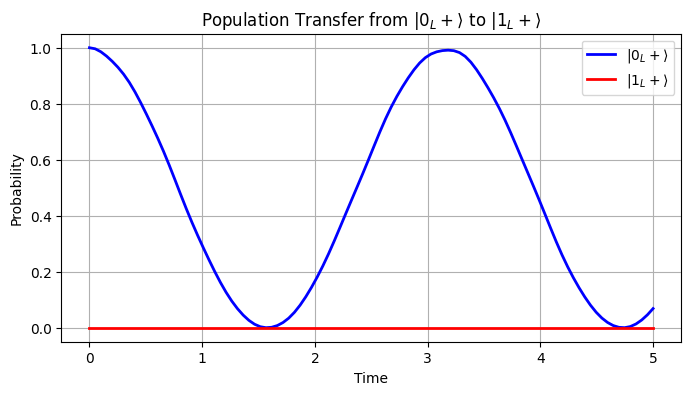

In [127]:
perturbation_factor = 0.06

H_gad, ks, V = prep_gadget(perturbation_factor, hs, total_logic_qbits)

X_L_gad = H_gad[0]

# Define logical states |0_L> and |1_L>
basis_states = [basis(2, 0), basis(2, 1)]
logical_zero = tensor([basis(2, 0) for _ in range(total_logic_qbits)])
logical_one = tensor([basis(2, 1) for _ in range(total_logic_qbits)])


# Modified H_S_0 with gadgets
initial_state = logical_zero

for k in ks:
    plus_state_anc = (tensor([basis(2, 0) for _ in range(k)]) + 
                      tensor([basis(2, 1) for _ in range(k)])).unit()
    initial_state = tensor(initial_state, plus_state_anc)
    logical_one = tensor(logical_one, plus_state_anc)
    
print_quantum_state_as_superposition(initial_state)


# Define the time-dependent Hamiltonian
H = sum(X_L_gad[:3]) + sum(X_L_gad[3:])

P0 = initial_state * initial_state.dag()
P1 = logical_one * logical_one.dag()

# Create the QobjEvo for the time-dependent Hamiltonian
H_pulse = QobjEvo(H)

# Solve the system using sesolve
result = sesolve(H_pulse, initial_state, times, e_ops=[P0, P1])

zero_exp_gad = result.expect[0]
one_exp_gad = result.expect[1]

print(zero_exp[-1], one_exp[-1])
# Plot results
plt.figure(figsize=(8, 4))
plt.plot(times, zero_exp_gad, label=r"$|0_{L}+\rangle$", color='blue', linewidth=2)
plt.plot(times, one_exp_gad, label=r"$|1_{L}+\rangle$", color='red', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Probability")
plt.title(r"Population Transfer from $|0_{L}+\rangle$ to $|1_{L}+\rangle$")
plt.legend()
plt.grid()
plt.show()


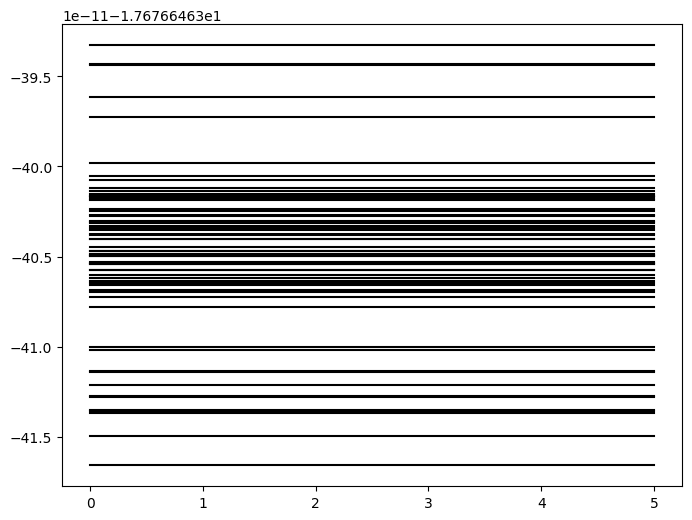

In [128]:
energy_spectrum = []
for t_step in times:
    H_t = H
    energies = H_t.eigenenergies()
    energy_spectrum.append(energies)
    
energy_spectrum = np.array(energy_spectrum)
n_qubits = 6
# Plot the energy spectrum
plt.figure(figsize=(8, 6))
for i in range(2**n_qubits):
    plt.plot(times, energy_spectrum[:, i], color='black')

In [129]:
def H_eff(perturbation_factor, hs, total_logic_qbits, T_protocol):
    times = np.linspace(0, T_protocol, 100)  # Time range for the evolution
    
    H_gad, ks, V = prep_gadget(perturbation_factor, hs, total_logic_qbits)

    H = 0
    for hgad in H_gad:
        H += sum(hgad[:3]) + sum(hgad[3:])
    
    # Define logical states |0_L> and |1_L>
    logical_zero = tensor([basis(2, 0) for _ in range(total_logic_qbits)])
    
    # Modified H_S_0 with gadgets
    initial_state = logical_zero
    
    for k in ks:
        plus_state_anc = (tensor([basis(2, 0) for _ in range(k)]) + 
                          tensor([basis(2, 1) for _ in range(k)])).unit()
        initial_state = tensor(initial_state, plus_state_anc)
    
    
    P0 = initial_state * initial_state.dag()
    
    # Create the QobjEvo for the time-dependent Hamiltonian
    H_pulse = QobjEvo(H)
    
    # Solve the system using sesolve
    result = sesolve(H_pulse, initial_state, times, e_ops=[P0], options={'nsteps': 1e6})
    
    zero_exp_gad = result.expect[0]
    return zero_exp_gad

def H_id(T_protocol, hs):
    H = 0
    for h in hs:
        H += tensor(h)
    
    times = np.linspace(0, T_protocol, 100)  # Time range for the evolution
    
    # Create the QobjEvo for the time-dependent Hamiltonian
    H_pulse = QobjEvo(H)
    
    # Define basis states for |000> and |111>
    state_000 = tensor([basis(2, 0) for _ in range(total_qubits)])
    
    P0 = state_000 * state_000.dag()
    
    # Solve the system using sesolve
    result = sesolve(H_pulse, state_000, times, e_ops=[P0])
    
    zero_exp = result.expect[0]
    return zero_exp

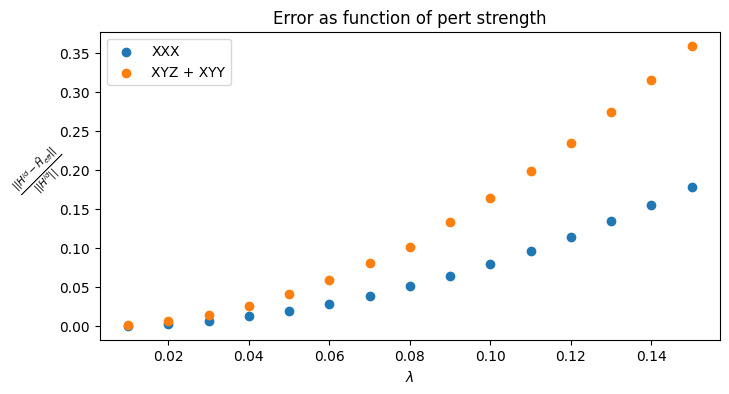

In [130]:
T_protocol = 10

XXX = [X, X, X]

hs1 = [XXX]
hs2 = [[X,Y,Z], [X,Y,Y]]
hss = [hs1, hs2] 
labels = ["XXX", "XYZ + XYY"]

perts = np.linspace(0.01, 0.15, 15)
plt.figure(figsize=(8, 4))
for i, hs in enumerate(hss):
    dists = []
    Hid = H_id(T_protocol, hs)

    for pert in perts:
        total_logic_qbits = len(hs[0])
        Heff = H_eff(pert, hs, total_logic_qbits, T_protocol)
        d = np.linalg.norm(Hid - Heff) / np.linalg.norm(Hid)
        dists.append(d)
    plt.scatter(perts, dists, label=labels[i])
        
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\frac{||H^{id} - \tilde{H}_{eff}||}{||H^{id}||}$", rotation=45)
plt.title(r"Error as function of pert strength")
plt.legend()
plt.show()